## MovieLen-100k data

## Initial setting for GGColab

In [1]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%pwd

'/content'

In [4]:
%cd "/content/drive/Othercomputers/Tam's Laptop/Desktop/study/rec_sys/als"

/content/drive/Othercomputers/Tam's Laptop/Desktop/study/rec_sys/als


In [5]:
%pwd

"/content/drive/Othercomputers/Tam's Laptop/Desktop/study/rec_sys/als"

## Preprocessing

In [6]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from recommenders.datasets.spark_splitters import spark_random_split
from recommenders.evaluation.spark_evaluation import SparkRankingEvaluation, SparkRatingEvaluation
from recommenders.tuning.parameter_sweep import generate_param_grid
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pandas as pd

In [7]:
# Khởi tạo SparkSession
spark = SparkSession.builder.appName("ALS rec sys").getOrCreate()

# Đọc tệp CSV vào DataFrame
mv_rating = spark.read.csv("data/ratings.csv", header=True, inferSchema=True)

# Hiển thị nội dung của DataFrame
mv_rating.show()


+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|     31|   2.5|1260759144|
|     1|   1029|   3.0|1260759179|
|     1|   1061|   3.0|1260759182|
|     1|   1129|   2.0|1260759185|
|     1|   1172|   4.0|1260759205|
|     1|   1263|   2.0|1260759151|
|     1|   1287|   2.0|1260759187|
|     1|   1293|   2.0|1260759148|
|     1|   1339|   3.5|1260759125|
|     1|   1343|   2.0|1260759131|
|     1|   1371|   2.5|1260759135|
|     1|   1405|   1.0|1260759203|
|     1|   1953|   4.0|1260759191|
|     1|   2105|   4.0|1260759139|
|     1|   2150|   3.0|1260759194|
|     1|   2193|   2.0|1260759198|
|     1|   2294|   2.0|1260759108|
|     1|   2455|   2.5|1260759113|
|     1|   2968|   1.0|1260759200|
|     1|   3671|   3.0|1260759117|
+------+-------+------+----------+
only showing top 20 rows



In [8]:
# Show random 5 rows:
mv_rating.sample(False, 0.1).show(5)

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     2|    253|   4.0| 835355511|
|     2|    300|   3.0| 835355532|
|     2|    382|   3.0| 835356165|
|     2|    587|   3.0| 835355779|
|     3|   2318|   4.0|1298861753|
+------+-------+------+----------+
only showing top 5 rows



In [9]:
# Count how many customer in the dataframe
mv_rating.createOrReplaceTempView('movielen')
spark.sql("SELECT Count(distinct userId) from movielen").show()

+----------------------+
|count(DISTINCT userId)|
+----------------------+
|                   671|
+----------------------+



In [10]:
# Add random age and gender to each user:
# age: random with range (18-50)
# gender: random in list (0: female, 1: male)
# --------------------------------------

# get distinct userid:
userids = spark.sql('select distinct userId from movielen').collect()
userids = [u['userId'] for u in userids]
print('user ids:', userids[:5])

# create a random age and gender dataframe for each userids:
random.seed(96)
user_age_gender_random_list = \
    [(u, random.randrange(18, 50), random.choice([0, 1])) for u in userids]
print('user_age_gender_random_list', user_age_gender_random_list[:5])

user_age_gender_random_df = spark.createDataFrame(
    user_age_gender_random_list, 
    ['userId', 'age', 'gender']
)
print('after random assigning age and gender:')
user_age_gender_random_df.show(5)

# merge to main df:
mv_rating = mv_rating.join(
    user_age_gender_random_df,
    on = 'userId',
    how = 'left'
)

user ids: [148, 463, 471, 496, 243]
user_age_gender_random_list [(148, 41, 1), (463, 43, 0), (471, 24, 1), (496, 20, 0), (243, 28, 1)]
after random assigning age and gender:
+------+---+------+
|userId|age|gender|
+------+---+------+
|   148| 41|     1|
|   463| 43|     0|
|   471| 24|     1|
|   496| 20|     0|
|   243| 28|     1|
+------+---+------+
only showing top 5 rows



In [11]:
# check null for all cols:
mv_rating.select(
    [count(when(col(c).isNull(), c)).alias(c) for c in mv_rating.columns]
    ).show()

mv_rating.show(5)
mv_rating.printSchema()


+------+-------+------+---------+---+------+
|userId|movieId|rating|timestamp|age|gender|
+------+-------+------+---------+---+------+
|     0|      0|     0|        0|  0|     0|
+------+-------+------+---------+---+------+

+------+-------+------+----------+---+------+
|userId|movieId|rating| timestamp|age|gender|
+------+-------+------+----------+---+------+
|     1|     31|   2.5|1260759144| 36|     0|
|     1|   1029|   3.0|1260759179| 36|     0|
|     1|   1061|   3.0|1260759182| 36|     0|
|     1|   1129|   2.0|1260759185| 36|     0|
|     1|   1172|   4.0|1260759205| 36|     0|
+------+-------+------+----------+---+------+
only showing top 5 rows

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)
 |-- age: long (nullable = true)
 |-- gender: long (nullable = true)



## Train model:

In [12]:
# Assigning global variables:
USER_COL = "userId"
ITEM_COL = "movieId"
RATING_COL = "rating"
PREDICT_COL = "prediction"
REC_QUANTITY = 5


In [13]:
# train test split:
df_train, df_test = mv_rating.randomSplit([0.7, 0.3], seed = 96)

In [14]:
# TRAIN MODEL WITH DEFAULT PARAMS:
#---------------------------------
als = ALS(
    userCol=    USER_COL, 
    itemCol=    ITEM_COL, 
    ratingCol=  RATING_COL, 
    coldStartStrategy="drop")

model = als.fit(df_train)

In [15]:
# prediction on test dataset:
df_test_prd = model.transform(df_test)
df_test_prd.show()

+------+-------+------+----------+---+------+----------+
|userId|movieId|rating| timestamp|age|gender|prediction|
+------+-------+------+----------+---+------+----------+
|     1|     31|   2.5|1260759144| 36|     0| 2.2777603|
|     1|   1129|   2.0|1260759185| 36|     0| 2.7084856|
|     1|   1287|   2.0|1260759187| 36|     0| 3.1102786|
|     1|   1293|   2.0|1260759148| 36|     0| 2.8692255|
|     1|   1343|   2.0|1260759131| 36|     0| 2.2297826|
|     1|   2968|   1.0|1260759200| 36|     0| 3.5180073|
|     2|     39|   5.0| 835355604| 27|     1|  3.393339|
|     2|     50|   4.0| 835355586| 27|     1|  3.910627|
|     2|    110|   4.0| 835355532| 27|     1|  3.905835|
|     2|    153|   4.0| 835355441| 27|     1| 2.2431989|
|     2|    165|   3.0| 835355441| 27|     1|   3.32084|
|     2|    185|   3.0| 835355511| 27|     1| 3.2474632|
|     2|    235|   3.0| 835355664| 27|     1|  2.322969|
|     2|    248|   3.0| 835355896| 27|     1| 2.9175234|
|     2|    265|   5.0| 8353556

In [16]:
# Evalualtion:
#------------------------------------------
evaluations = SparkRatingEvaluation(
    df_test, 
    df_test_prd,
    col_user=USER_COL,
    col_item=ITEM_COL,
    col_rating=RATING_COL,
    col_prediction=PREDICT_COL
)

print(
    "MSE score = {}".format(evaluations.rmse()**2),
    "RMSE score = {}".format(evaluations.rmse()),
    "MAE score = {}".format(evaluations.mae()),
    "R2 score = {}".format(evaluations.rsquared()),
    "Explained variance score = {}".format(evaluations.exp_var()),
    sep="\n"
)


/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


MSE score = 0.8645836192048755
RMSE score = 0.9298298872400669
MAE score = 0.7181212312486204
R2 score = 0.2144780661324045
Explained variance score = 0.24443788954210421


In [17]:
users = df_train.select(USER_COL).distinct()
items = df_train.select(ITEM_COL).distinct()
user_item = users.crossJoin(items)
user_item.show()

+------+-------+
|userId|movieId|
+------+-------+
|   148|   1580|
|   463|   1580|
|   471|   1580|
|   496|   1580|
|   243|   1580|
|   392|   1580|
|   540|   1580|
|   623|   1580|
|    31|   1580|
|   516|   1580|
|    85|   1580|
|   137|   1580|
|   251|   1580|
|   451|   1580|
|   580|   1580|
|    65|   1580|
|   458|   1580|
|    53|   1580|
|   255|   1580|
|   481|   1580|
+------+-------+
only showing top 20 rows



In [18]:
df_train_cross_pred = model.transform(user_item)
df_train_cross_pred.show()

+------+-------+----------+
|userId|movieId|prediction|
+------+-------+----------+
|   148|   1580|  4.018919|
|   463|   1580| 3.6338956|
|   471|   1580| 3.9132962|
|   496|   1580|  4.430628|
|   243|   1580| 3.6232831|
|   392|   1580| 2.8646984|
|   540|   1580|  3.357282|
|   623|   1580|  3.820676|
|    31|   1580| 3.9288785|
|   516|   1580| 3.9508808|
|    85|   1580| 3.7451944|
|   137|   1580|  4.153893|
|   251|   1580| 4.0835223|
|   451|   1580|  3.236604|
|   580|   1580|  3.152354|
|    65|   1580|  3.217188|
|   458|   1580|  3.679392|
|    53|   1580| 3.2540224|
|   255|   1580| 3.2255995|
|   481|   1580|  3.570278|
+------+-------+----------+
only showing top 20 rows



In [19]:
df_train.show()

+------+-------+------+----------+---+------+
|userId|movieId|rating| timestamp|age|gender|
+------+-------+------+----------+---+------+
|     1|   1029|   3.0|1260759179| 36|     0|
|     1|   1061|   3.0|1260759182| 36|     0|
|     1|   1172|   4.0|1260759205| 36|     0|
|     1|   1263|   2.0|1260759151| 36|     0|
|     1|   1339|   3.5|1260759125| 36|     0|
|     1|   1371|   2.5|1260759135| 36|     0|
|     1|   1405|   1.0|1260759203| 36|     0|
|     1|   1953|   4.0|1260759191| 36|     0|
|     1|   2105|   4.0|1260759139| 36|     0|
|     1|   2150|   3.0|1260759194| 36|     0|
|     1|   2193|   2.0|1260759198| 36|     0|
|     1|   2294|   2.0|1260759108| 36|     0|
|     1|   2455|   2.5|1260759113| 36|     0|
|     1|   3671|   3.0|1260759117| 36|     0|
|     2|     10|   4.0| 835355493| 27|     1|
|     2|     17|   5.0| 835355681| 27|     1|
|     2|     47|   4.0| 835355552| 27|     1|
|     2|     52|   3.0| 835356031| 27|     1|
|     2|     62|   3.0| 835355749|

In [20]:
# Remove seen movies:
df_train_cross_pred.createOrReplaceTempView('df_train_cross_pred')
df_train.createOrReplaceTempView('df_train')

df_train_exclude_seen_item_prd = spark.sql(f'''
    SELECT 
        pred.*
    FROM df_train_cross_pred AS pred
    FULL OUTER JOIN df_train AS train
    ON pred.{USER_COL} = train.{USER_COL} AND pred.{ITEM_COL} = train.{ITEM_COL}
    WHERE train.userId IS NULL
''')
df_train_exclude_seen_item_prd.show()


+------+-------+----------+
|userId|movieId|prediction|
+------+-------+----------+
|     1|      1| 3.0186527|
|     1|      2| 2.3228128|
|     1|      3| 2.4942095|
|     1|      4| 1.5943217|
|     1|      7| 1.3576819|
|     1|      8|   2.05047|
|     1|      9| 1.4947327|
|     1|     11| 2.1697998|
|     1|     16| 3.0686839|
|     1|     19| 2.1317992|
|     1|     20| 1.1721728|
|     1|     22| 2.4089153|
|     1|     23| 1.7534119|
|     1|     25| 3.1546972|
|     1|     26|   2.81678|
|     1|     32| 3.2732918|
|     1|     36| 2.8951337|
|     1|     37| 1.9137537|
|     1|     39|  2.951846|
|     1|     41|  3.039481|
+------+-------+----------+
only showing top 20 rows



In [21]:
evaluations = SparkRankingEvaluation(
    df_test, 
    df_train_exclude_seen_item_prd,
    col_user=USER_COL,
    col_item=ITEM_COL,
    col_rating=RATING_COL,
    col_prediction=PREDICT_COL,
    k = REC_QUANTITY
)

print(
    "Precision@k = {}".format(evaluations.precision_at_k()),
    "Recall@k = {}".format(evaluations.recall_at_k()),
    "NDCG@k = {}".format(evaluations.ndcg_at_k()),
    "Mean average precision = {}".format(evaluations.map_at_k()),
    sep="\n"
)

Precision@k = 0.003278688524590167
Recall@k = 0.00043616990404878844
NDCG@k = 0.0030557932922071107
Mean average precision = 0.00013648664139774016


## Finetuning model

Prediction performance of a Spark ALS model is often affected by the parameters

|Parameter|Description|Default value|Notes|
|-------------|-----------------|------------------|-----------------|
|`rank`|Number of latent factors|10|The larger the more intrinsic factors considered in the factorization modeling.|
|`regParam`|Regularization parameter|1.0|The value needs to be selected empirically to avoid overfitting.|
|`maxIters`|Maximum number of iterations|10|The more iterations the better the model converges to the optimal point.|

It is always a good practice to start model building with default parameter values and then sweep the parameter in a range to find the optimal combination of parameters. The following parameter set is used for training ALS models for comparison study purposes.

### 1st time:

In [22]:
param_dict = {
    "rank": [10, 15, 20],
    "regParam": [0.001, 0.1, 1.0],
    # 'maxIter': [7, 10, 15, 20]
}
param_grid = generate_param_grid(param_dict)
param_grid

[{'rank': 10, 'regParam': 0.001},
 {'rank': 10, 'regParam': 0.1},
 {'rank': 10, 'regParam': 1.0},
 {'rank': 15, 'regParam': 0.001},
 {'rank': 15, 'regParam': 0.1},
 {'rank': 15, 'regParam': 1.0},
 {'rank': 20, 'regParam': 0.001},
 {'rank': 20, 'regParam': 0.1},
 {'rank': 20, 'regParam': 1.0}]

In [23]:
rmse_score = []

for g in param_grid:
    als = ALS(        
        userCol=USER_COL, 
        itemCol=ITEM_COL, 
        ratingCol=RATING_COL, 
        coldStartStrategy="drop",
        **g # assigning each of param
    )
    
    model = als.fit(df_train)
    
    df_test_pred = model.transform(df_test).drop(RATING_COL)
    
    evaluations = SparkRatingEvaluation(
        df_test, 
        df_test_pred,
        col_user=USER_COL,
        col_item=ITEM_COL,
        col_rating=RATING_COL,
        col_prediction=PREDICT_COL
    )

    rmse_score.append(evaluations.rmse())

rmse_score = [float('%.4f' % x) for x in rmse_score]
rmse_score_array = np.reshape(
    rmse_score, (len(param_dict["rank"]), len(param_dict["regParam"]))
    ) 

In [24]:
rmse_score_array

array([[1.4408, 0.9298, 1.3324],
       [1.5383, 0.9266, 1.3324],
       [1.5941, 0.9258, 1.3324]])

In [25]:
rmse_score

[1.4408, 0.9298, 1.3324, 1.5383, 0.9266, 1.3324, 1.5941, 0.9258, 1.3324]

<Axes: xlabel='reg. parameter', ylabel='rank'>

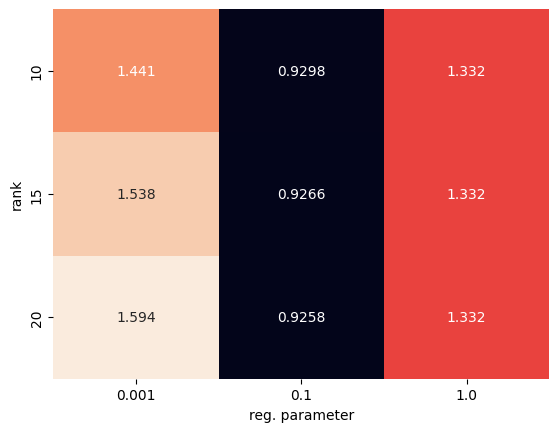

In [34]:

rmse_df = pd.DataFrame(data=rmse_score_array, index=pd.Index(param_dict["rank"], name="rank"), 
                       columns=pd.Index(param_dict["regParam"], name="reg. parameter"))

fig, ax = plt.subplots()
sns.heatmap(rmse_df, cbar=False, annot=True, fmt=".4g")

with rank 20 and reg is 0.1 is the best one, let's try again

### 2nd time

In [44]:
param_dict = {
    "rank": [100, 150, 200, 250, 300, 350],
    "regParam": [0.1],
    # 'maxIter': [7, 10, 15, 20]
}
param_grid = generate_param_grid(param_dict)
param_grid

[{'rank': 100, 'regParam': 0.1},
 {'rank': 150, 'regParam': 0.1},
 {'rank': 200, 'regParam': 0.1},
 {'rank': 250, 'regParam': 0.1},
 {'rank': 300, 'regParam': 0.1},
 {'rank': 350, 'regParam': 0.1}]

In [45]:
rmse_score = []

for g in param_grid:
    als = ALS(        
        userCol=USER_COL, 
        itemCol=ITEM_COL, 
        ratingCol=RATING_COL, 
        coldStartStrategy="drop",
        **g # assigning each of param
    )
    
    model = als.fit(df_train)
    
    df_test_pred = model.transform(df_test).drop(RATING_COL)
    df_train_pred = model.transform(df_train).drop(RATING_COL)
    
    evaluations_test = SparkRatingEvaluation(
        df_test, 
        df_test_pred,
        col_user=USER_COL,
        col_item=ITEM_COL,
        col_rating=RATING_COL,
        col_prediction=PREDICT_COL
    )
    evaluations_train = SparkRatingEvaluation(
        df_train, 
        df_train_pred,
        col_user=USER_COL,
        col_item=ITEM_COL,
        col_rating=RATING_COL,
        col_prediction=PREDICT_COL
    )

    rmse_score.append(
        (evaluations_train.rmse(), evaluations_test.rmse())
    )

# rmse_score = [float('%.4f' % x) for x in rmse_score]
# rmse_score_array = np.reshape(
#     rmse_score, (len(param_dict["rank"]), len(param_dict["regParam"]))
#     ) 

In [46]:
rmse_score

[(0.43491516892981097, 0.9182868331036531),
 (0.4351262682942047, 0.9167033979913759),
 (0.4344752509667622, 0.9174207987999587),
 (0.43370552050806105, 0.9184324915631141),
 (0.4341642999148613, 0.9171785714839016),
 (0.4339014694849286, 0.9175482385096286)]

In [43]:
rmse_score

[(0.4888194617880013, 0.9257932886743929),
 (0.4544823365236682, 0.9210914580843299),
 (0.44433855704104663, 0.9202055056809606),
 (0.44079236363804153, 0.9178096642837069),
 (0.43795167767408766, 0.918337592113715),
 (0.43775880428046515, 0.9170233254344575)]

<Axes: xlabel='reg. parameter', ylabel='rank'>

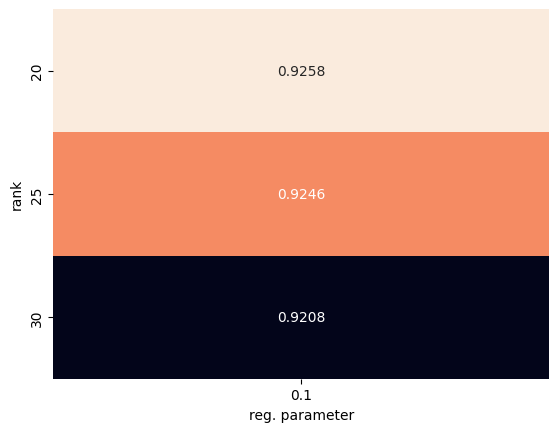

In [37]:
rmse_df = pd.DataFrame(data=rmse_score_array, index=pd.Index(param_dict["rank"], name="rank"), 
                       columns=pd.Index(param_dict["regParam"], name="reg. parameter"))

fig, ax = plt.subplots()
sns.heatmap(rmse_df, cbar=False, annot=True, fmt=".4g")